In [1]:
import sys
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
d = os.path.dirname(os.getcwd())
sys.path.insert(0, d)

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

from torchvision.datasets import CIFAR10
from torchvision import transforms


from utils.train_utils import ModelTrainer, plot_history
from models.wide_resnet import WideResNet
from models.resnet import *
from utils.attacks import pgd

In [3]:
tr_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])
vl_transform = transforms.Compose([
    transforms.ToTensor()
])

ds_train = CIFAR10('../data', train=True, download=True, transform=tr_transform)
ds_test = CIFAR10('../data', train=False, download=True, transform=vl_transform)

Files already downloaded and verified
Files already downloaded and verified


# Wide-ResNet

## Natural training

cuda
1
Epoch: 1 Validation Loss: 1.2444 accuracy: 0.5577, time: 0:01:09                
Epoch: 2 Validation Loss: 0.8574 accuracy: 0.6973, time: 0:01:08                
Epoch: 3 Validation Loss: 0.7032 accuracy: 0.7524, time: 0:01:08                
Epoch: 4 Validation Loss: 0.6731 accuracy: 0.7725, time: 0:01:08                
Epoch: 5 Validation Loss: 0.5887 accuracy: 0.7939, time: 0:01:08                
Epoch: 6 Validation Loss: 0.5579 accuracy: 0.8155, time: 0:01:07                
Epoch: 7 Validation Loss: 0.5956 accuracy: 0.7974, time: 0:01:08                
epochs_no_improve: 1/8
Epoch: 8 Validation Loss: 0.5080 accuracy: 0.8272, time: 0:01:07                
Epoch: 9 Validation Loss: 0.4966 accuracy: 0.8359, time: 0:01:07                
Epoch: 10 Validation Loss: 0.5191 accuracy: 0.8320, time: 0:01:07               
epochs_no_improve: 1/8
Epoch: 11 Validation Loss: 0.3782 accuracy: 0.8746, time: 0:01:07               
Epoch: 12 Validation Loss: 0.5908 accuracy: 0.8104, time

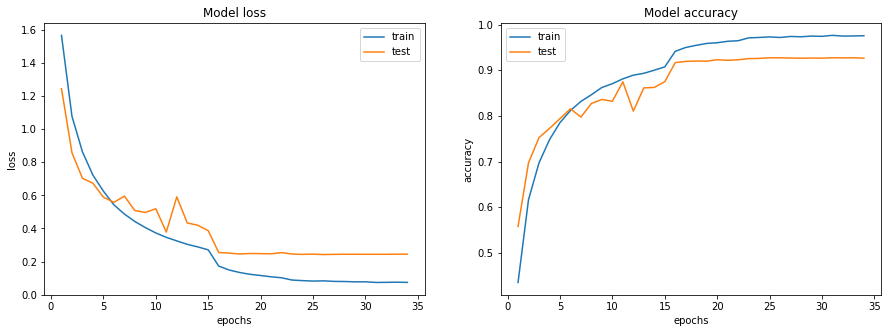

In [7]:
trainer = ModelTrainer(ds_train, ds_test, is_sparse=False, batch_size=100)

model = resnet18()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=3e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', min_lr=1e-7, patience=3, verbose=True)

history = trainer.train(model, loss_fn, optimizer, scheduler, epochs=50, patience=8)
plot_history(history)
torch.save(model.state_dict(), "../saved/resnet18.pt")

torch.cuda.empty_cache()

## Adversarial Training

In [6]:
attack_params = {
    "epsilon": 8/255,
    "alpha": 2/255,
    "num_iter": 10
}

cuda
Epoch: 1 Validation Loss: 1.2458 accuracy: 0.6113, time: 0:06:54                
Epoch: 2 Validation Loss: 1.1063 accuracy: 0.6437, time: 0:06:54                
Epoch: 3 Validation Loss: 1.1142 accuracy: 0.6393, time: 0:06:53                
epochs_no_improve: 1/8
Epoch: 4 Validation Loss: 1.0423 accuracy: 0.6877, time: 0:06:53                
Epoch: 5 Validation Loss: 1.0242 accuracy: 0.7008, time: 0:08:01                
Epoch: 6 Validation Loss: 0.9768 accuracy: 0.7019, time: 0:08:14                
Epoch: 7 Validation Loss: 0.9490 accuracy: 0.7070, time: 0:08:43                
Epoch: 8 Validation Loss: 0.9362 accuracy: 0.7149, time: 0:08:47                
Epoch: 9 Validation Loss: 0.8968 accuracy: 0.7367, time: 0:08:49                
Epoch: 10 Validation Loss: 0.8800 accuracy: 0.7420, time: 0:08:48               
Epoch: 11 Validation Loss: 0.9160 accuracy: 0.7228, time: 0:08:49               
epochs_no_improve: 1/8
Epoch: 12 Validation Loss: 0.8595 accuracy: 0.7414, time: 

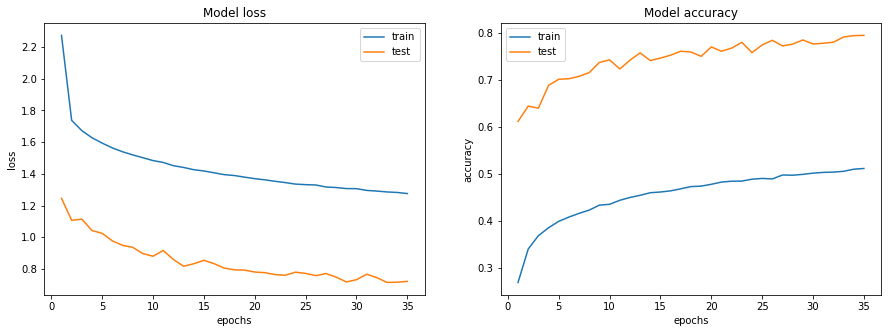

In [7]:
trainer = ModelTrainer(ds_train, ds_test, is_sparse=False, batch_size=100)
model = resnet18()
model.load_state_dict(torch.load("../saved/resnet18.pt", map_location=trainer.device))

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=3e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', min_lr=1e-6, patience=3, verbose=True)

history = trainer.adv_train(model, pgd, attack_params, loss_fn, optimizer, scheduler, epochs=35, patience=8)
plot_history(history)
torch.save(model.state_dict(), "../saved/resnet18_AT.pt")

torch.cuda.empty_cache()